In [8]:
import sys
import os
os.chdir("C:\\Users\\Zber\\Documents\\Dev_program\\OpenRadar")
import numpy as np
import mmwave.dsp as dsp
import mmwave.dsp.music as music
import mmwave.clustering as clu
from mmwave.dataloader import DCA1000
from demo.visualizer.visualize import ellipse_visualize
from FER.data_processing.mediapipe_facemesh_one import flm_detector, distance
from scipy import signal

from mmwave.dsp.utils import Window
from mmwave.dsp import utils
import math
from FER.utils import parseConfigFile, arange_tx

from itertools import accumulate
from operator import add
from mmwave.dsp.cfar import ca

from scipy.signal import find_peaks, peak_widths
# import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')

from mpl_toolkits.mplot3d import Axes3D

from mmwave.dsp.cfar import ca, ca_, cago_, caso_, os_

plt.close('all')

DebugMode = True

if not DebugMode:
    import matplotlib

    matplotlib.use('Agg')

# plotting color
import matplotlib._color_data as mcd

tab_color = [mcd.TABLEAU_COLORS[name] for name in mcd.TABLEAU_COLORS]
extra_color = ['#acc2d9', '#56ae57', '#b2996e', '#a8ff04']
tab_color = tab_color + extra_color

# figpath = "C:/Users/Zber/Desktop/mmWave_figure"
figpath = "C:/Users/Zber/Desktop/SavedFigure"
configFileName = 'C:/Users/Zber/Desktop/mmWave Configuration/profile_3d_aop_3s.cfg'

In [9]:
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Multi_People/Surprise_fan_100cm_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Multi_People/Surprise_100cm_fan_0_Raw_0.bin"
adc_data_path = "C:/Users/Zber/Desktop/Subjects/Multi_People/Surprise_100cm_fan_movePeople_9_Raw_0.bin"

In [10]:
# num Antennas
numTxAntennas = 3
numRxAntennas = 4
# load configure parameters
config = parseConfigFile(configFileName)

# mmWave radar settings
numFrames = config['numFrames']
numADCSamples = config['numAdcSamples']
numLoopsPerFrame = config['numLoops']
numChirpsPerFrame = numTxAntennas * numLoopsPerFrame
numAngleBins = 64

# aoa related
VIRT_ELE_PAIRS = [[8, 2], [9, 3], [10, 4], [11, 5]]
VIRT_AZI_PAIRS = [[i for i in range(0, 8)]]

# azimuth
ANGLE_RES_AZI = 1
ANGLE_RANGE_AZI = 90
ANGLE_BINS_AZI = (ANGLE_RANGE_AZI * 2) // ANGLE_RES_AZI + 1
VIRT_ANT_AZI = 8

# elevation
ANGLE_RES_ELE = 1
ANGLE_RANGE_ELE = 30
ANGLE_BINS_ELE = (ANGLE_RANGE_ELE * 2) // ANGLE_RES_ELE + 1
VIRT_ANT_ELE = 2

BIN_RANG_S = 0
BIN_RANG_E = 256
BINS_PROCESSED = BIN_RANG_E - BIN_RANG_S
VIRT_ANT_AZI_INDEX = [i for i in range(0, 8)]
VIRT_ANT_ELE_INDEX = VIRT_ELE_PAIRS[2]

# data processing parameter
range_resolution, bandwidth = dsp.range_resolution(config['numAdcSamples'],
                                                    dig_out_sample_rate=config['digOutSampleRate'],
                                                    freq_slope_const=config['freqSlopeConst'])

doppler_resolution = dsp.doppler_resolution(bandwidth, start_freq_const=config['startFreq'],
                                            ramp_end_time=config['rampEndTime'],
                                            idle_time_const=config['idleTime'],
                                            num_loops_per_frame=config['numLoops'],
                                            num_tx_antennas=numTxAntennas)

print('Range Resolution: {:.2f}cm, Bandwidth: {:.2f}Ghz, Doppler Resolution: {:.2f}m/s'.format(
    range_resolution * 100, bandwidth / 1000000000, doppler_resolution))


Range Resolution: 4.22cm, Bandwidth: 3.56Ghz, Doppler Resolution: 0.43m/s


In [11]:
# Reading in adc data
adc_data = np.fromfile(adc_data_path, dtype=np.int16)
adc_data = adc_data.reshape(numFrames, -1)
# adc_data = np.apply_along_axis(DCA1000.organize_cli, 1, adc_data, num_chirps=numChirpsPerFrame,
#                                 num_rx=numRxAntennas, num_samples=numADCSamples)
adc_data = np.apply_along_axis(DCA1000.organize_cli, 1, adc_data, num_chirps=numChirpsPerFrame,
                                num_rx=numRxAntennas, num_samples=numADCSamples)
print("Data Loaded!")

# processing range data
# window types : Bartlett, Blackman p, Hanning p and Hamming
# range_data = dsp.range_processing(adc_data, window_type_1d=Window.HANNING)
range_data = dsp.range_processing(adc_data)
range_data = arange_tx(range_data, num_tx=numTxAntennas)

Data Loaded!


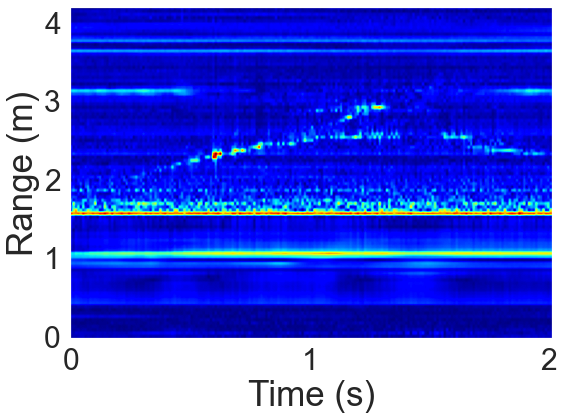

In [12]:
# range profile
plt.rcParams["axes.grid"] = False
unit = 0.042158314406249994
fig5, axes5 = plt.subplots(1, 1, figsize=(8, 6))
range_plot_data = np.abs(np.mean(range_data[50:250,15,:,0:],axis=(1)))
range_plot_data[:, 20:23] = range_plot_data[:, 20:23]/3
range_plot_data[:, 23:25] = range_plot_data[:, 23:25]/3
# range_plot_data[:, 0:9] = range_plot_data[:,90:99]
# range_plot_data[:, 0:10] = range_plot_data[:,100:110]*2
range_plot_data[:, 0:10] = range_plot_data[:,100:110]
range_plot_data = range_plot_data[:, :100]
range_plot_data = range_plot_data[:, ::-1]
range_plot_data = range_plot_data.T

y_txt = np.arange(0,5, step=1)
y_pos = 99 - y_txt/unit
axes5.set_yticks(y_pos)
axes5.set_yticklabels(y_txt,fontsize=30)


x_txt = np.arange(0,3,step= 1)
x_pos = x_txt * 99
axes5.set_xticks(x_pos)
axes5.set_xticklabels(x_txt,fontsize=30)

axes5.set_ylabel("Range (m)",fontsize=35)

axes5.set_xlabel("Time (s)",fontsize=35)


# range_plot_data = range_data[50:250,15,11,0:110]
# range_plot_data = np.mean(range_data,axis=(1,2))
# range_plot_data = range_data[:,15,2,:50]


# axes5.imshow(np.abs(range_plot_data.T), cmap=plt.get_cmap('jet'))
axes5.imshow(range_plot_data, cmap=plt.get_cmap('jet'), aspect='auto')
fig5.tight_layout()
# fig5.savefig('C:/Users/Zber/Desktop/mmEmo_Exp/0.Method/ambient_rangeProfile.svg',format='svg', bbox_inches="tight")

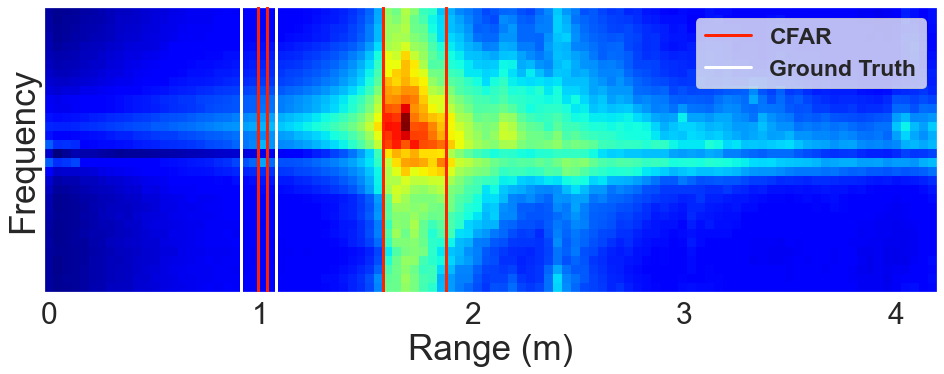

In [13]:
# %matplotlib widget
s_bin = 0
e_bin = s_bin + 100
# %matplotlib inline
fig, axes = plt.subplots(1, 1, figsize=(16, 8))
det_matrix, aoa_input = dsp.doppler_processing_frame(range_data, num_tx_antennas=numTxAntennas,
                                                     clutter_removal_enabled=True,
                                                     window_type_2d=Window.HAMMING,
                                                     accumulate=True)

# det_matrix, aoa_input = doppler_processing(range_data, num_tx_antennas=numTxAntennas,
#                                                     clutter_removal_enabled=True,
#                                                     window_type_2d=Window.HAMMING,
#                                                     accumulate=True)

det_matrix_vis = np.fft.fftshift(det_matrix, axes=2)
det_matrix_vis_mean = np.mean(det_matrix_vis[:, :, :], axis=0)
# det_matrix_vis_mean = np.mean(det_matrix_vis[50:100, :, :], axis=0)
bin_data = det_matrix_vis_mean[:, 17] + det_matrix_vis_mean[:, 15]

peak_data = ca(bin_data, guard_len=2, noise_len=4, l_bound=8)[s_bin:e_bin]


# axes.plot(peak_data)
# axes.axvline(x=20, color='r', linestyle='-')
# axes.axvline(x=24, color='r', linestyle='-')
doppler_plot = np.abs(det_matrix_vis_mean.T[:, s_bin:e_bin])

# axes.imshow(doppler_plot, cmap=plt.get_cmap('jet'))
axes.imshow(doppler_plot, cmap=plt.get_cmap('jet'))

xcoods = [23.5, 24.5, 37.5, 44.5]
for xc in xcoods:
    if xc == xcoods[0]:
        axes.axvline(x=xc, c='#ff2100', lw=3, zorder=5, label='CFAR')
    else:
        axes.axvline(x=xc, c='#ff2100', lw=3, zorder=5)


xcoods = [21.5, 25.5]
for xc in xcoods:
    if xc == xcoods[0]:
        axes.axvline(x=xc, c='white', lw=3, zorder=5, label='Ground Truth')
    else:
        axes.axvline(x=xc, c='white', lw=3, zorder=5)

y_txt = np.arange(0,5, step=1)
y_pos = y_txt/unit
axes.set_xlabel("Range (m)",fontsize=35)
axes.set_ylabel("Frequency",fontsize=35)
axes.set_yticks([])
axes.set_xticks(y_pos)
axes.set_xticklabels(y_txt,fontsize=30)
axes.legend( prop={'size': 23, 'weight':'bold'})
# axes.legend( loc="upper left", prop={'size': 25, },ncol=3,bbox_to_anchor=(0.15, 1.2),
#             fancybox=True, framealpha=0.0,labelspacing=0.1,handletextpad = 0.3,columnspacing=0.5,handlelength = 1.1)
# fig.savefig('C:/Users/Zber/Desktop/mmEmo_Exp/0.Method/fan_rangeDoppler.svg',format='svg', bbox_inches="tight")



In [15]:
g_data = np.mean(range_plot_data[:100], axis=0)
grad_data = np.abs(np.diff(g_data))

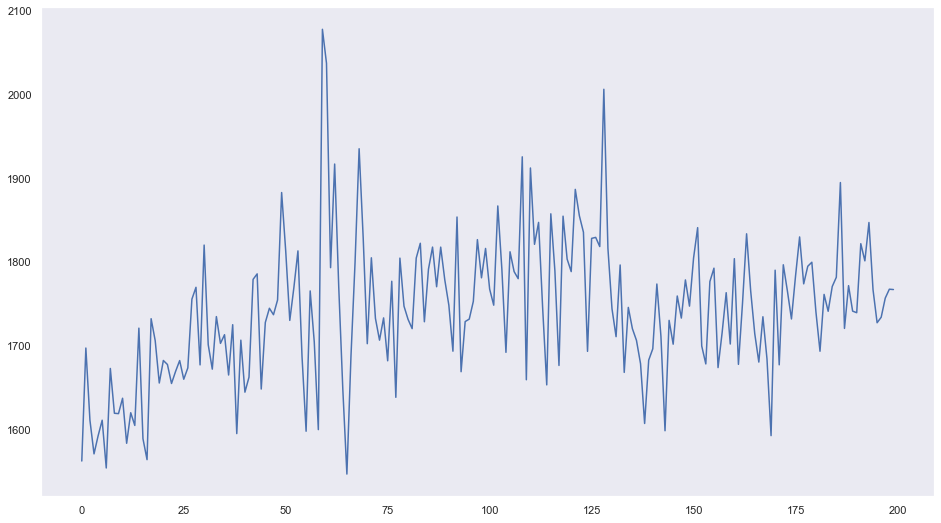

In [17]:
gg_data = np.mean(range_plot_data[:100], axis=0)
# gg_grad_data = np.log10(gg_data) * 20 
fig4, axes4 = plt.subplots(1, 1, figsize=(16, 9))
axes4.plot(np.abs(gg_data))

In [ ]:
fig3, axes3 = plt.subplots(1, 1, figsize=(16, 9))
axes3.plot(grad_data)
threshold, noise_floor = ca_(grad_data, guard_len=5, noise_len=10, l_bound=13, mode='wrap')
# threshold, noise_floor = caso_(grad_data, guard_len=2, noise_len=5, l_bound=6, mode='wrap')

peaks = (grad_data > threshold)
x=np.arange(0, len(grad_data), 1)[peaks]
y=grad_data[peaks]

In [ ]:
gg_data = np.mean(range_plot_data[:100], axis=0)
# gg_grad_data = np.log10(gg_data) * 20 
fig4, axes4 = plt.subplots(1, 1, figsize=(16, 9))
axes4.plot(np.abs(gg_data))

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(16, 9))
pad = np.zeros((32, 100))
pad[:, peak_data] = doppler_plot[:, peak_data]
axes.imshow(pad, cmap=plt.get_cmap('jet'))
plt.plot()